In [ ]:
print("Hello World!")

In [ ]:
#All imports
import torch
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import skimage.transform as skTrans
import altair as alt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
#import umap


In [ ]:
import numpy as np

In [ ]:
#Initialize pretrained model
device = torch.device('cpu')
checkpoint = torch.load('age_expansion_8_model_low_loss.pth.tar', map_location=device)
model_state_dict = checkpoint['state_dict']
from models import NetWork
model = NetWork(in_channel=3, feat_dim=1024) #should be 1024

In [ ]:
#TEST: pass one image thru the model
image1 = nib.load('Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information/Patient-1/1-T1.nii')
data = image1.get_fdata()
print(data.shape)
data = skTrans.resize(data, (3,100,100,100), order=1, preserve_range=True)
print(data.shape)
#data = data.transpose(2, 0, 1)
data = (data - data.mean()) / data.std()
data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
data = data.to(device)
output = model(data, age_id=None)

(512, 512, 19)
(3, 100, 100, 100)


In [ ]:
#Extract Features from all files in a folder.

results = []
root_path = 'T1_Files'

# Need a regular expression to extract patient ID and diagnosis from filenames
id_pattern = re.compile(r'(\d{4})_\d+?_([A-Z]{2})\.nii')

# Go through all files in the directory
for file_name in os.listdir(root_path):

    # Use the regular expression to extract the patient ID and diagnosis from the filename
    match = id_pattern.match(file_name)

    if match:
        patient_id = int(match.group(1))  # Convert ID to integer to remove leading zeros
        diagnosis = match.group(2)

        image_path = os.path.join(root_path, file_name)

        # Load image
        image = nib.load(image_path)
        data = image.get_fdata()

        data = skTrans.resize(data, (3,100,100,100), order=1, preserve_range=True)

        data = (data - data.mean()) / data.std()

        # Convert to PyTorch tensor and adjust dimensions
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        data = data.to(device)

        # Forward pass through the model
        output = model(data, age_id=None).squeeze().detach().cpu().numpy()

        # Store results
        for index, value in enumerate(output):
            results.append({'PatientID': patient_id, 'Diagnosis': diagnosis, 'FeatureValue': value.item(), 'FeatureIndex': index})

# Create a Pandas DataFrame from the dic of results
df = pd.DataFrame(results)

print(df)
df.to_excel("MS_AD_HC_Features.xlsx")  #should specify index = False next time


        PatientID Diagnosis  FeatureValue  FeatureIndex
0              72        HC     -0.016757             0
1              72        HC     -0.340019             1
2              72        HC      0.301406             2
3              72        HC     -0.227406             3
4              72        HC     -0.236615             4
...           ...       ...           ...           ...
116731        109        AD     -0.111144          1019
116732        109        AD      0.095493          1020
116733        109        AD      0.138586          1021
116734        109        AD      0.661451          1022
116735        109        AD      0.333888          1023

[116736 rows x 4 columns]


In [ ]:
#If kernel dies

df = pd.read_excel("MS_AD_HC_Features.xlsx")
print(df)
df.head()

        PatientID Diagnosis  FeatureValue  FeatureIndex
0              72        HC     -0.016757             0
1              72        HC     -0.340019             1
2              72        HC      0.301406             2
3              72        HC     -0.227406             3
4              72        HC     -0.236615             4
...           ...       ...           ...           ...
116731        109        AD     -0.111144          1019
116732        109        AD      0.095493          1020
116733        109        AD      0.138586          1021
116734        109        AD      0.661451          1022
116735        109        AD      0.333888          1023

[116736 rows x 4 columns]


,PatientID,Diagnosis,FeatureValue,FeatureIndex
0,72,HC,-0.016757,0
1,72,HC,-0.340019,1
2,72,HC,0.301406,2
3,72,HC,-0.227406,3
4,72,HC,-0.236615,4


In [ ]:
#Let's decide how many PCA components we want


# Pivot the DataFrame to get one row per patient with all features
df_pivot = df.pivot(index='PatientID', columns='FeatureIndex', values='FeatureValue')

#get the info
X = df_pivot.values

# standardize the features
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA
pca = PCA()

# Fit PCA to  the scaled data
pca.fit(X_scaled)

# Create a dataframe w/ the cumulative explained variance
explained_variance_df = pd.DataFrame({
    'Component': range(1, len(pca.explained_variance_ratio_) + 1),
    'Cumulative Explained Variance': np.cumsum(pca.explained_variance_ratio_)
})


cumulative_variance_chart = alt.Chart(explained_variance_df).mark_line(point=True).encode(
    alt.X('Component:O').title('Components'),
    y='Cumulative Explained Variance:Q'
).properties(
    title='Cumulative Explained Variance by Different Principal Components'
)

cumulative_variance_chart.display()


alt.Chart(...)

In [ ]:
#Apply PCA!


# Pivot the DataFrame to get one row per patient with 1024 feature columns
features = df.pivot(index='PatientID', columns='FeatureIndex', values='FeatureValue')

#features data frame now has one row per patient and 1024 columns for features

# now standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
n_components = 100  # The number of components to keep, based on above chart
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components,
                            index=features.index,
                            columns=[f'PC{i}' for i in range(1, n_components + 1)])

# Reset index to bring PatientID back as a column
principal_df.reset_index(inplace=True)


# Now, extract the unique 'PatientID' and 'Diagnosis' from the original df
patient_info = df[['PatientID', 'Diagnosis']].drop_duplicates().set_index('PatientID')

# Merge the patient info and the principal components dataframes
final_df = patient_info.join(principal_df.set_index('PatientID')).reset_index()

print(final_df)
principal_df.head()

     PatientID Diagnosis        PC1        PC2        PC3        PC4  \
0           72        HC -17.644127   0.758157  -1.105755  -0.108460   
1           92        AD -17.345358  -0.501753  -0.012666  -0.550627   
2           57        MS  11.297910  19.701075  16.295537  18.140019   
3          102        AD -17.193518  -0.264689  -1.779100  -1.135225   
4           31        MS  13.758450 -10.477612  12.276509  -2.044534   
..         ...       ...        ...        ...        ...        ...   
109         77        HC -16.259503   0.180252   0.250583  -1.603220   
110         44        MS  15.777120  -9.022601  -1.332415  -6.179885   
111         10        MS  13.794281   0.548339   7.786463  -9.606041   
112         84        AD -17.910196  -1.420690  -0.736062  -1.213158   
113        109        AD -17.555659  -0.801310  -0.493535  -1.240863   

           PC5        PC6       PC7        PC8  ...      PC91      PC92  \
0    -0.640160   0.402727  0.371382   0.409910  ... -3.70361

,PatientID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,1,11.125146,-8.796279,-7.965404,6.875864,-8.662986,3.361407,-0.105935,-3.480209,-8.972061,...,-0.295635,0.479045,0.243611,0.157652,0.092125,0.015205,-0.168853,0.089897,-0.080003,0.239678
1,2,18.603305,7.096793,7.284930,-6.333760,5.257012,-13.366622,-6.689003,2.734631,-8.424408,...,-0.341940,0.343626,0.548000,1.207176,0.237619,-0.414604,-0.595895,0.120274,0.180808,0.509162
2,3,13.382476,15.723444,-2.094530,-1.786593,-5.520615,0.568097,-15.571590,7.619640,-1.117828,...,0.381724,0.133167,-0.668173,-0.369027,-0.230597,0.368767,0.060551,-0.013856,0.213651,-0.184034
3,4,15.075393,-7.904023,-13.735031,7.385967,-3.169482,-2.481729,5.187532,3.038856,1.521624,...,0.462592,1.186163,-0.174072,0.258783,-0.483358,0.256420,-0.321421,-0.778230,0.281364,-0.529187
4,5,17.462549,-6.079522,-9.535018,-3.300259,5.652220,-0.915562,2.527011,0.485876,5.483226,...,-0.313888,-0.313963,0.343898,-0.467804,-1.264306,1.430567,0.129597,-0.472686,0.351288,-0.108455


In [ ]:
#Apply t-SNE!


# Select the feature columns for t-SNE
feature_columns = [f'PC{i}' for i in range(1, n_components + 1)]

# Extract feature data
feature_data = final_df[feature_columns]

# Apply t-SNE
n_components_tsne = 2  #2 components for viz
tsne = TSNE(n_components=n_components_tsne, random_state=42)
tsne_results = tsne.fit_transform(feature_data)

tsne_df = pd.DataFrame(data=tsne_results, columns=[f't-SNE{i}' for i in range(1, n_components_tsne + 1)])

tsne_final_df = pd.concat([final_df[['PatientID', 'Diagnosis']].reset_index(drop=True), tsne_df], axis=1)

scatter_plot = alt.Chart(tsne_final_df).mark_circle(size=60).encode(
    x='t-SNE1',
    y='t-SNE2',
    color='Diagnosis:N',  # Color by Diagnosis
    tooltip=['PatientID', 'Diagnosis']
).properties(
    width=500,
    height=400
)

scatter_plot



alt.Chart(...)

In [ ]:
#Try DensMap instead of t-SNE?



# Initialize the UMAP object
reducer = umap.UMAP()

# Fit the model to the PCA data and transform it
embedding = reducer.fit_transform(principal_df.iloc[:, 1:])  # exclude the PatientID column and Diagnosis

# The resulting 'embedding' array can be turned into a DataFrame for convenience
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# Combine the embedding with the patient info
final_df = pd.concat([principal_df[['PatientID']], embedding_df], axis=1)

final_df.head()


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
MS_df = MS_df.replace({'Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information':'MS'})
MS_df.head()

,PatientID,FeatureValue,FeatureIndex,DataSet
0,33,-0.817514,0,MS
1,33,-0.113724,1,MS
2,33,0.402695,2,MS
3,33,0.444876,3,MS
4,33,0.054612,4,MS


In [ ]:
#Visualize distribution of each feature.

#feature 1
feat1 = df[df['FeatureIndex']==0]
chart1 = alt.Chart(feat1, title="TITLE KYNA").encode(
    alt.X('OutputValue', bin=True),
    y='count()'
).mark_bar()

chart1

import altair as alt


# Create a dictionary to store the charts
charts = {}

# Iterate over unique values in the 'OutputIndex' column
for output_index in df['FeatureIndex'].unique():
    # Filter DataFrame for the specific feature
    feat_data = df[df['FeatureIndex'] == output_index]

    # Create a chart for the feature
    chart = alt.Chart(feat_data, title=f"Feature {output_index}").encode(
        alt.X('FeatureValue', bin=True).title("Feature Value (binned)"),#.scale(domain = (-2,2)),
        alt.Y('count()').title("Count")
    ).mark_bar()

    # Store the chart in the dictionary
    charts[f'chart{output_index}'] = chart

(charts['chart0']|charts['chart1']|charts['chart2']|charts['chart3']|charts['chart4'])&(charts['chart5']|charts['chart6']|charts['chart7']|charts['chart8']|charts['chart9'])


#or can plot featurex vs featurey matrix with colour as classification

alt.VConcatChart(...)

[[  -1.     0.     0.   255.5]
 [   0.     1.     0.  -255.5]
 [   0.     0.     1.    -9. ]
 [   0.     0.     0.     1. ]] 
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b'          '
db_name         : b'                  '
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 32
dim             : [  3 512 512  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'                                                                                '
aux_file        : b'

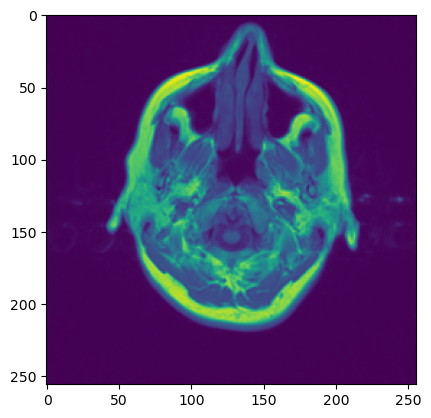

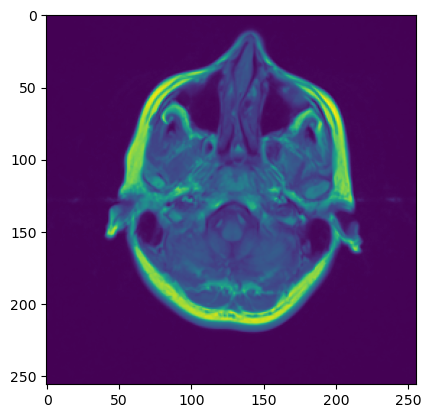

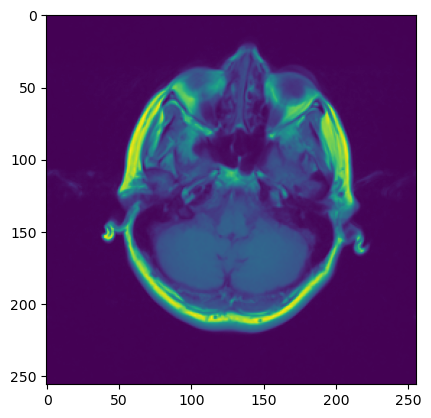

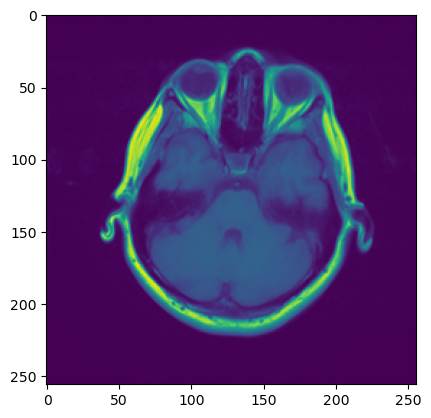

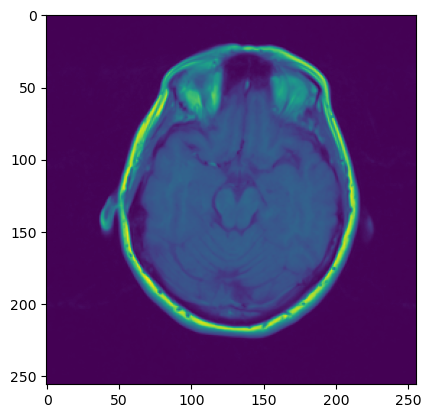

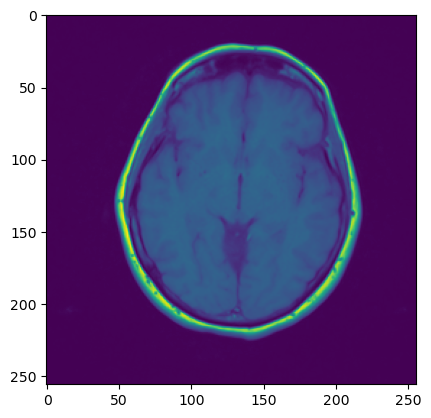

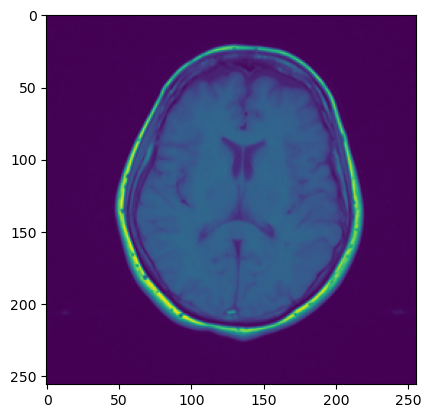

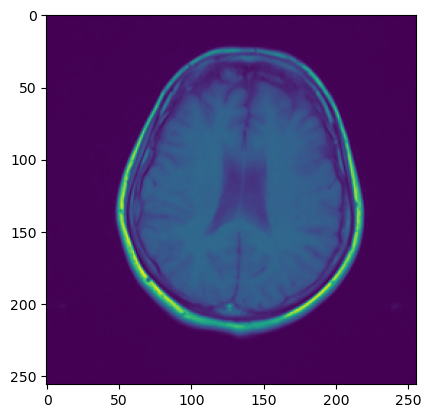

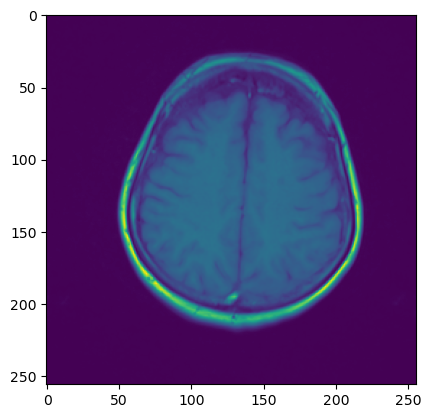

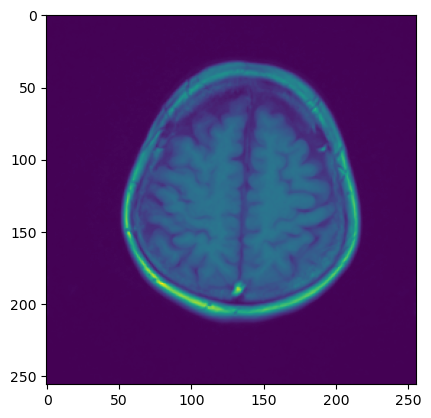

In [ ]:
my_img = nib.load('Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information/Patient-1/1-T1.nii')
nii_data = my_img.get_fdata()
nii_data = skTrans.resize(nii_data, (256,256,10), order=1, preserve_range=True)
nii_aff  = my_img.affine
nii_hdr  = my_img.header
print(nii_aff ,'\n',nii_hdr)
print(nii_data.shape)
if(len(nii_data.shape)==3):
   for slice_Number in range(nii_data.shape[2]):
       plt.imshow(nii_data[:,:,slice_Number ])
       plt.show()
if(len(nii_data.shape)==4):
   for frame in range(nii_data.shape[3]):
       for slice_Number in range(nii_data.shape[2]):
           plt.imshow(nii_data[:,:,slice_Number,frame])
           plt.show()